In [101]:
# Import all the libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import datetime
from sklearn.metrics import r2_score, mean_squared_error
import plotly.graph_objs as go
import seaborn as sns

This code builds the fina

The dataset used for final model building has combined data from -
1. MCI dataset
2. Toronto Police Personnel details (https://data.torontopolice.on.ca/datasets/personnel-by-rank-by-division-asr-pb-tbl-003/explore)
3. Neighbourhood Profile (https://open.toronto.ca/dataset/neighbourhood-profiles/)
4. Calculated Crime Rate Analysis (From Part-1 notebook)

In [83]:
raw_df = pd.read_excel("output4.xlsx")
raw_df.head(2)

,EVENT_UNIQUE_ID,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DAY,OCC_DOY,OCC_DOW,OCC_HOUR,time_of_day,DIVISION,...,HOOD_140,NEIGHBOURHOOD_140,Division,Count_of_police_force,Neighbourhood_x,Average Individual Employment Income,Population,Unemployment Rate,Low Income population(LIM-AT),mean_rate_scaled
0,GO-20201282,2020-01-01,2020,January,1,1,Wednesday,3,Midnight,D51,...,77,Waterfront Communities-The Island,51 Division,289.0,Waterfront Communities-The Island,"72,028","65,913",5.2,"10,820",0.059276
1,GO-20201649,2020-01-01,2020,January,1,1,Wednesday,5,Day,D31,...,24,Black Creek,31 Division,223.0,Black Creek,"27,575","21,737",12.7,"7,105",0.223682


In [84]:
raw_df1 = raw_df

In [85]:
# Group the data by OCC_DOY (day of the year)
grouped = raw_df1.groupby('OCC_DOY')

# Calculate the sum of incidents for each day of the year
sum_incidents = grouped['EVENT_UNIQUE_ID'].count()

# Create a new dataframe with the day of the year and the sum of incidents
incidents_by_day = pd.DataFrame({'OCC_DOY': sum_incidents.index, 'sum_of_incidents': sum_incidents.values})

# Merge the new dataframe with the original dataframe
raw_df1 = pd.merge(raw_df1, incidents_by_day, on='OCC_DOY')

In [86]:
grouped_df = raw_df.groupby(["NEIGHBOURHOOD_140", "OCC_DOY", "OCC_DOW", "time_of_day"])

In [87]:
# Group the data by NEIGHBOURHOOD_140, OCC_DOY, OCC_DOW, and time_of_day
grouped = raw_df1.groupby(['NEIGHBOURHOOD_140', 'OCC_DOY', 'OCC_DOW', 'time_of_day'])

# Calculate the count of incidents for each group
count = grouped['EVENT_UNIQUE_ID'].count()

# Merge the count of incidents with the original dataframe
raw_df1 = raw_df1.merge(count, on=['NEIGHBOURHOOD_140', 'OCC_DOY', 'OCC_DOW', 'time_of_day'], suffixes=('', '_count'))

# Calculate the incident score by dividing the count of incidents by the total crimes in that year
raw_df1['incident_score'] = raw_df1['EVENT_UNIQUE_ID_count'] / raw_df1['sum_of_incidents']

In [88]:
raw_df1.head(5)

,EVENT_UNIQUE_ID,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DAY,OCC_DOY,OCC_DOW,OCC_HOUR,time_of_day,DIVISION,...,Count_of_police_force,Neighbourhood_x,Average Individual Employment Income,Population,Unemployment Rate,Low Income population(LIM-AT),mean_rate_scaled,sum_of_incidents,EVENT_UNIQUE_ID_count,incident_score
0,GO-20201282,2020-01-01,2020,January,1,1,Wednesday,3,Midnight,D51,...,289.0,Waterfront Communities-The Island,"72,028","65,913",5.2,"10,820",0.059276,426,5,0.011737
1,GO-2020236,2020-01-01,2020,January,1,1,Wednesday,0,Midnight,D14,...,280.0,Waterfront Communities-The Island,"72,028","65,913",5.2,"10,820",0.059276,426,5,0.011737
2,GO-2020808,2020-01-01,2020,January,1,1,Wednesday,2,Midnight,D52,...,253.0,Waterfront Communities-The Island,"72,028","65,913",5.2,"10,820",0.059276,426,5,0.011737
3,GO-202052982,2020-01-01,2020,January,1,1,Wednesday,1,Midnight,D14,...,280.0,Waterfront Communities-The Island,"72,028","65,913",5.2,"10,820",0.059276,426,5,0.011737
4,GO-20202443858,2020-01-01,2020,January,1,1,Wednesday,0,Midnight,D51,...,289.0,Waterfront Communities-The Island,"72,028","65,913",5.2,"10,820",0.059276,426,5,0.011737


In [89]:
# Plotting the incident_score data
# Creating a histogram of the incident score using Plotly
fig = go.Figure()
fig.add_trace(go.Histogram(x=raw_df1['incident_score'], nbinsx=10))

# Updating the layout of the plot
fig.update_layout(
    title="Distribution of Incident Score",
    xaxis_title="Incident Score",
    yaxis_title="Count",
    font=dict(size=18),
    margin=dict(l=50, r=50, t=80, b=50),
    height=600,
    width=800
)

# Displaying the plot
fig.show()

In [90]:
# Scaling 'incident_score' using Min-Max scaling to normalise the data
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the "incident_score" column and transform it
raw_df1['incident_score_scaled'] = scaler.fit_transform(raw_df1[['incident_score']])

In [94]:
# Plotting the normalised incident_score data
# Creating a histogram of the incident score using Plotly
fig = go.Figure()
fig.add_trace(go.Histogram(x=raw_df1['incident_score_scaled'], nbinsx=10))

# Updating the layout of the plot
fig.update_layout(
    title="Distribution of Scaled Incident Score",
    xaxis_title="Incident Score(Scaled)",
    yaxis_title="Count",
    font=dict(size=18),
    margin=dict(l=50, r=50, t=80, b=50),
    height=600,
    width=800
)

# Displaying the plot
fig.show()

In [95]:
# Adding a new column for recency: The more recent a crime has happened in a neighbourhood higher the chance happening it sooner
current_date = datetime.datetime.today().date()
raw_df1['recency'] = (current_date - pd.to_datetime(raw_df1['OCC_DATE']).dt.date).dt.days

<ipython-input-106-62f86820e2e7>:15: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



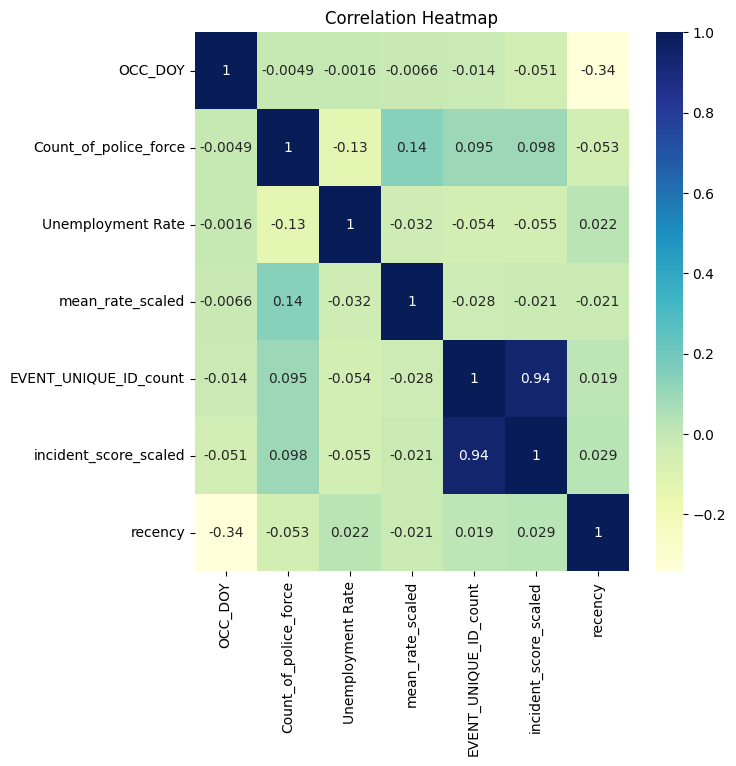

In [106]:
# Correlation heatmap
import matplotlib.pyplot as plt
raw_df3 = raw_df1
# Dropping unnecessary columns
raw_df3 = raw_df3.drop(['EVENT_UNIQUE_ID', 'OCC_DATE', 'OCC_DAY','OCC_MONTH',
                        'OCC_HOUR', 'LOCATION_TYPE', 'PREMISES_TYPE', 'Neighbourhood_x',
                        'incident_score', 'sum_of_incidents', 'OFFENCE', 'MCI_CATEGORY',
                        'HOOD_140', 'Division', 'OCC_YEAR'], axis=1)

# Removing commas from the numeric columns and converting them to float
raw_df3["Average Individual Employment Income"] = raw_df3["Average Individual Employment Income"].replace(",", "")
raw_df3["Population"] = raw_df3["Population"].replace(",", "")
raw_df3["Low Income population(LIM-AT)"] = raw_df3["Low Income population(LIM-AT)"].replace(",", "")

# Creating a correlation matrix
corr_matrix = raw_df3.corr()

# Creating a heatmap of the correlation matrix
plt.figure(figsize=(7,7))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap")
plt.show()

# The final model built predicts the incident_score, which indicates the probability of crime happening given a particular neighbourhood, day of year, day of week and time of day.

In [120]:
# Creating CatBoost model

#Assigning data
raw_df2 = raw_df1
# Drop the irrelevant columns
raw_df2 = raw_df2.drop(['EVENT_UNIQUE_ID', 'OCC_DATE', 'OCC_DAY','OCC_MONTH',
                        'OCC_HOUR', 'LOCATION_TYPE', 'PREMISES_TYPE', 'Neighbourhood_x',
                        'incident_score', 'sum_of_incidents', 'OFFENCE', 'MCI_CATEGORY',
                        'HOOD_140', 'Division', 'OCC_YEAR'], axis=1)


# Removing the comma from the number
raw_df2["Average Individual Employment Income"] = raw_df2["Average Individual Employment Income"].replace(",", "")
raw_df2["Population"] = raw_df2["Population"].replace(",", "")
raw_df2["Low Income population(LIM-AT)"] = raw_df2["Low Income population(LIM-AT)"].replace(",", "")

raw_df2[['Average Individual Employment Income', 'Population', 'Low Income population(LIM-AT)']] = raw_df2[['Average Individual Employment Income', 'Population', 'Low Income population(LIM-AT)']].apply(pd.to_numeric, errors='coerce')


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(raw_df2.drop('incident_score_scaled', axis=1), raw_df2['incident_score_scaled'], test_size=0.2, random_state=42)

# Define the categorical features
cat_features = ['OCC_DOY', 'OCC_DOW', 'time_of_day', 'DIVISION',  'NEIGHBOURHOOD_140']

# Create a CatBoostRegressor object
model = CatBoostRegressor(iterations=150, learning_rate=0.01, depth=8, boosting_type='Ordered', loss_function='RMSE')

# Fit the model to the training data
model.fit(X_train, y_train, cat_features=cat_features, verbose=False)


In [121]:
# Make predictions on the training and testing datasets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the R-squared values for the training and testing datasets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the R-squared values
print('R-squared for training set:', r2_train)
print('R-squared for testing set:', r2_test)

# Evaluate the model on the testing data
y_pred = model.predict(X_test)

# Calculate the MSE
mse = mean_squared_error(y_test, y_pred)

# Print the R-squared and MSE
print('MSE:', mse)

R-squared for training set: 0.8520484924880306
R-squared for testing set: 0.8440406114718463
MSE: 0.0012060703164649591


We can see below the factors affecting the crime rate

In [111]:
# Checking feature importance
df_feature_importance

,Feature Id,Importances
0,EVENT_UNIQUE_ID_count,94.372467
1,recency,4.420323
2,time_of_day,0.437349
3,mean_rate_scaled,0.353892
4,Unemployment Rate,0.146375
5,Count_of_police_force,0.117387
6,OCC_DOW,0.097593
7,Low Income population(LIM-AT),0.054615
8,OCC_DOY,0.000000
9,DIVISION,0.000000


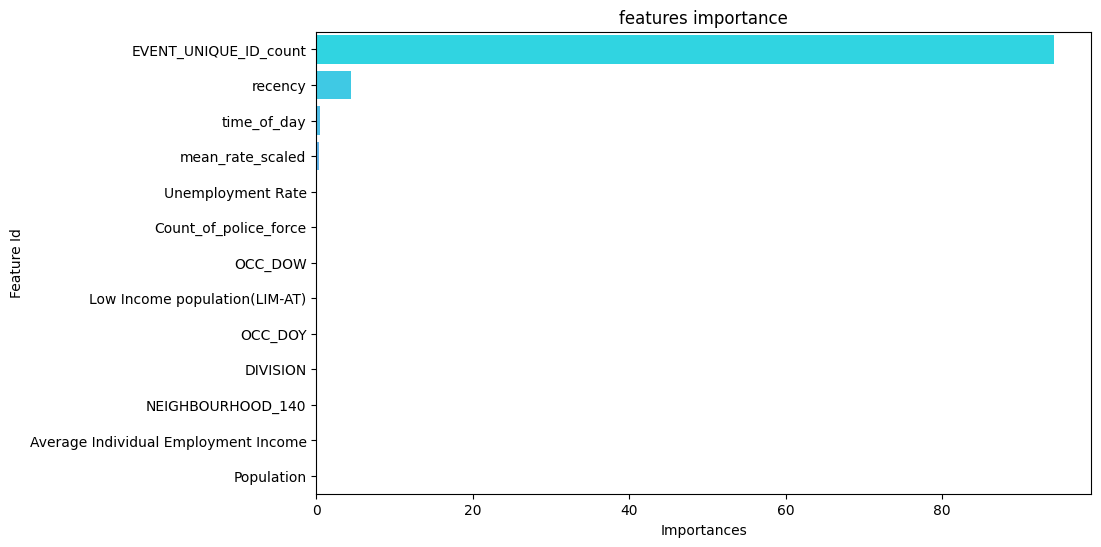

In [112]:
import seaborn as sns
# Create a dataframe of feature importance
df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True))
#plotting feature importance
plt.figure(figsize=(10, 6));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool");
plt.title('features importance');